Grid post-processing of Met.no data using SHyFT API
=========

### This notebook gives an example of Met.no data post-processing to correct temperature forecasts based on comparison to observations. The following steps are described:
1. **Loading required python modules and setting path to SHyFT installation**
2. **Create synthetic data for observation time-series**
3. **Create synthetic data for forecast time-series**
4. **Calculate correction bias between observations and forecasts**
5. **Apply bias correction to forecast time-series**
6. **Plot the results**

### 1. Loading required python modules and setting path to SHyFT installation

In [1]:
# First you should import the third-party python modules
# The first line enables that figures are shown inline, directly in the notebook
%pylab inline
from matplotlib import pyplot as plt

# If you want to use your own local build of shyft, you can set the path or the environment PYTHONPATH
# import os, sys
# from os import path
# sys.path.insert(0, os.path.abspath("../../../shyft"))

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
# To import shyft, it is enough to activate the conda environment where shyft is installed

from shyft.hydrology.repository.default_state_repository import DefaultStateRepository
from shyft.hydrology.orchestration.configuration import yaml_configs
from shyft.hydrology.orchestration.simulators.config_simulator import ConfigSimulator
import shyft.hydrology as api
import shyft.time_series as sts

# If you have problems here, it may be related to having your LD_LIBRARY_PATH
# pointing to the appropriate libboost_python libraries (.so files)

In [3]:
# Now you can access the shyft api with tab completion and help, try this:
# help(api.GeoPoint) # remove the hashtag and run the cell to print the documentation of the api.GeoPoint class
# api. # remove the hashtag, set the pointer behind the dot and use tab completion to see the available attributes

### 2. Create synthetic data for observation time-series

In [4]:
# Create time-axis starting 01.01.2016, sampled every hour for 10 days long
t0 = sts.Calendar().time(2016, 1, 1)
ta = sts.TimeAxis(t0, sts.deltahours(1), 240)

# Create a set of geo-locations at observation points (sparse set covering the forecast grid)
obs_locs = api.GeoPointVector()
obs_locs.append(api.GeoPoint( 100, 100,   10))
obs_locs.append(api.GeoPoint(5100, 100,  250))
obs_locs.append(api.GeoPoint( 100, 5100, 250))
obs_locs.append(api.GeoPoint(5100, 5100, 500))

# Create a set of time-series at observation points, having constant value
obs_set = api.GeoPointSourceVector()
for loc in obs_locs:
    obs_set.append(api.GeoPointSource(loc, sts.TimeSeries(ta, fill_value=10,point_fx=sts.POINT_AVERAGE_VALUE)))

# Create a set of geo-locations at forecast points (evenly spaced grid of 10 x 10 km)
fc_locs = api.GeoPointVector()
for x in range(10):
    for y in range(10):
        fc_locs.append(api.GeoPoint(x*1000, y*1000, (x+y)*50))

# Spread the set of observations to forecast locations by ordinary Kriging
obs_grid = api.ordinary_kriging(obs_set, fc_locs, ta.fixed_dt, api.OKParameter())

In [5]:
# Define a function to calculate the deviation in percent
def deviation(v1, v2):
    d = abs(v1 - v2)
    if v1:
        d = 100 * abs(d / v1)
    return d

### 3. Create synthetic data for forecast time-series

In [6]:
# Create an empty forecast grid
fc_grid = api.PrecipitationSourceVector()

# Create a synthetic bias time-serie
bias_ts = sts.TimeSeries(ta, fill_value=1,point_fx=sts.POINT_AVERAGE_VALUE)

# Create forecast time-series by adding the synthetic bias to the observation time-series
for obs in obs_grid:
    fc_grid.append(api.PrecipitationSource(obs.mid_point(), obs.ts + bias_ts))

# Create a forecast set to observation locations by IDW transform
fc_set = api.idw_precipitation(fc_grid, obs_locs, ta.fixed_dt, api.IDWPrecipitationParameter())

# Check deviation of grid mapping vs observation locations
d = deviation(fc_grid[0].ts.value(0), fc_set[0].ts.value(0))
print('The deviation of grid mapping is {0:.2f}%'.format(d))

The deviation of grid mapping is 0.01%


### 4. Calculate correction bias between observations and forecasts

In [7]:
# Create an empty bias set
bias_set = api.GeoPointSourceVector()

# Calculate the bias as a correction factor between observation and forecast timeseries at observation locations
for (obs, fc) in zip(obs_set, fc_set):
    bias_set.append(api.GeoPointSource(obs.mid_point(), obs.ts / fc.ts))
    
# Spread the bias from observation locations to forecast locations by ordinary kriging
bias_grid = api.ordinary_kriging(bias_set, fc_locs, ta.fixed_dt, api.OKParameter())

print('The correction factor at the first forecast location is {0:.3f}'.format(bias_grid[0].ts.value(0)))

The correction factor at the first forecast location is 0.909


### 5. Apply bias correction to forecast time-series

In [8]:
# Apply bias correction to forecast time-series at forecast locations
for (fc, bias) in zip(fc_grid, bias_grid):
    fc.ts = fc.ts * bias.ts

# Transform corrected forecasts to observation locations by IDW transform
fc_set = api.idw_precipitation(fc_grid, obs_locs, ta.fixed_dt, api.IDWPrecipitationParameter())

# Check deviation of corrected forecast vs observation
d = deviation(obs_set[0].ts.value(0), fc_set[0].ts.value(0))
print('The deviation of corrected forecast is {0:.2f}%'.format(d))

The deviation of corrected forecast is 0.01%


### 6. Plot the results

Text(0, 0.5, 'Precipitation')

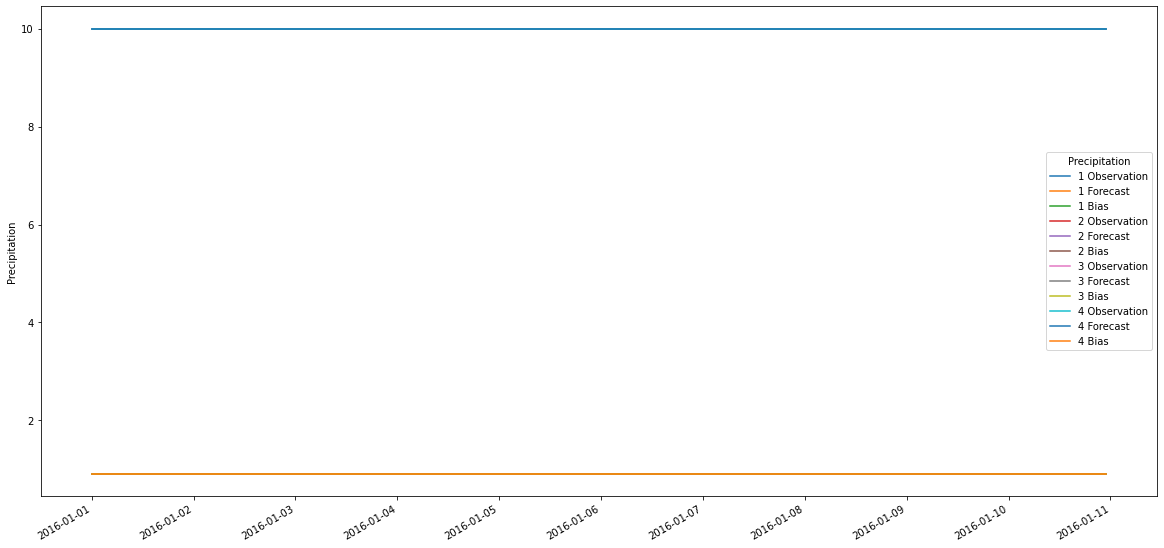

In [9]:
# Make a plot of time-series
fig, ax = plt.subplots(figsize=(20, 10))
for i in range(len(bias_set)):
    timestamps = [datetime.datetime.utcfromtimestamp(p) for p in obs_set[i].ts.time_axis.time_points][:-1]
    ax.plot(timestamps, obs_set[i].ts.values, label = str(i+1) + ' Observation')
    ax.plot(timestamps, fc_set[i].ts.values, label = str(i+1) + ' Forecast')
    ax.plot(timestamps, bias_set[i].ts.values, label = str(i+1) + ' Bias')
fig.autofmt_xdate()
ax.legend(title='Precipitation')
ax.set_ylabel('Precipitation')

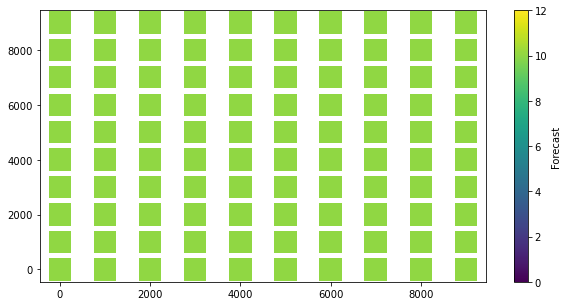

In [10]:
# Make a scatter plot of grid forecasts at ts.value(0)
x = [fc.mid_point().x for fc in fc_grid]
y = [fc.mid_point().y for fc in fc_grid]
fig, ax = plt.subplots(figsize=(10, 5))
vals = np.array([fc.ts.value(0) for fc in fc_grid])
v120 = max(vals) * 1.2 # Set color scale to 120% of max value
plot = ax.scatter(x, y, c=vals, marker='s', vmin=0, vmax=v120, s=500, lw=0)
plt.colorbar(plot).set_label('Forecast')

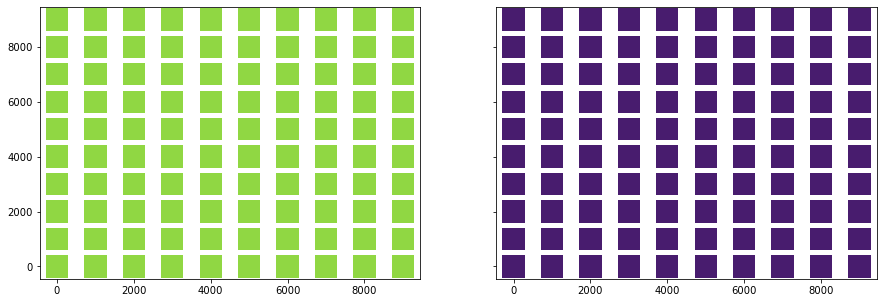

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15,5))
vals = np.array([obs.ts.value(0) for obs in obs_grid])
ax1.scatter(x, y, c=vals, marker='s', vmin=0, vmax=v120, s=500, lw=0)
vals = np.array([bias.ts.value(0) for bias in bias_grid])
ax2.scatter(x, y, c=vals, marker='s', vmin=0, vmax=v120, s=500, lw=0)
#plt.colorbar(plot).set_label('Observations vs. bias')